# Automated Trading System with Demo Plot
- Synthetic data fallback
- ML predictor with Decision Tree
- Visualization of price, signals, and portfolio value

### 1. Importing Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import annotations
import logging
from datetime import datetime
from typing import List

# Financial indicators
from ta.momentum import RSIIndicator

# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Colored console output
from colorama import Fore, Style, init
init(autoreset=True)

### 2.Configure logging 

In [35]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")
logger = logging.getLogger(__name__)


### 3.Data Ingestion 

In [36]:
class DataIngestion:
    def __init__(self, symbols: List[str]):
        self.symbols = symbols
        logger.info(f"Initialized DataIngestion for symbols: {symbols}")

    def fetch_historical_data(self, symbol: str, days: int = 10) -> pd.DataFrame:
        logger.info(f"Fetching {days} days of synthetic data for {symbol}")
        base_prices = {'RELIANCE': 2500, 'TCS': 3600, 'INFY': 1500}
        base_price = base_prices.get(symbol, 1000)

        dates = pd.date_range(end=datetime.now(), periods=days, freq='D')
        returns = np.random.normal(0.001, 0.05, days)
        prices = base_price * (1 + returns).cumprod()

        df = pd.DataFrame({
            'Date': dates,
            'Open': prices * (1 + np.random.uniform(-0.01, 0.01, days)),
            'High': prices * (1 + np.random.uniform(0, 0.02, days)),
            'Low': prices * (1 - np.random.uniform(0, 0.02, days)),
            'Close': prices,
            'Volume': np.random.randint(1000000, 10000000, days)
        })
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        return df


### 4.Technical Analysis 

In [37]:
class TechnicalAnalysis:
    @staticmethod
    def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['RSI'] = RSIIndicator(close=df['Close'], window=5).rsi().fillna(50)
        df['Returns'] = df['Close'].pct_change().fillna(0)
        logger.info("Technical indicators added")
        return df


### 5.Trading Strategy 

In [38]:
class TradingStrategy:
    def __init__(self, rsi_buy: int = 48, rsi_sell: int = 52):
        self.rsi_buy = rsi_buy
        self.rsi_sell = rsi_sell

    def generate_signals(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['Signal'] = 0
        holding = False

        for i in range(len(df)):
            if not holding and df['RSI'].iloc[i] < self.rsi_buy:
                df.loc[df.index[i], 'Signal'] = 1   # BUY
                holding = True
            elif holding and df['RSI'].iloc[i] > self.rsi_sell:
                df.loc[df.index[i], 'Signal'] = -1  # SELL
                holding = False

        df['Position'] = df['Signal'].replace(0, np.nan).ffill().fillna(0)
        return df


### 6.Backtester 

In [39]:
class Backtester:
    def __init__(self, initial_capital: float = 100000):
        self.initial_capital = initial_capital

    def backtest(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['Strategy_Returns'] = df['Position'].shift(1).fillna(0) * df['Returns']
        df['Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod()
        df['Portfolio_Value'] = self.initial_capital * df['Cumulative_Returns']
        trades = df[df['Signal'] != 0].copy()
        trades['Trade_Type'] = trades['Signal'].map({1: 'BUY', -1: 'SELL'})
        return df, trades


### 7.ML Predictor  

In [40]:
class MLPredictor:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()

    def train(self, df: pd.DataFrame):
        if len(df) < 5:
            logger.warning("Not enough data to train ML model properly")
            return None, "UNKNOWN"

        df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
        features = ['RSI', 'Returns']
        df = df.dropna()
        X = df[features]
        y = df['Target']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.model = DecisionTreeClassifier(max_depth=3, random_state=42)
        self.model.fit(X_train_scaled, y_train)
        y_pred = self.model.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        next_day_pred = self.model.predict(self.scaler.transform(X.iloc[[-1]]))[0]
        return accuracy, "UP" if next_day_pred == 1 else "DOWN"


### 8.Plot Function 

In [41]:
def plot_demo(df: pd.DataFrame, trades: pd.DataFrame, symbol: str):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
    buys = trades[trades['Trade_Type'] == 'BUY']
    sells = trades[trades['Trade_Type'] == 'SELL']
    ax1.scatter(buys.index, buys['Close'], marker='^', color='green', s=100, label='Buy')
    ax1.scatter(sells.index, sells['Close'], marker='v', color='red', s=100, label='Sell')
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['Portfolio_Value'], label='Portfolio Value', color='orange', linestyle='--')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax2.set_ylabel('Portfolio Value', color='orange')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f"{symbol} Demo: Price, Trades, and Portfolio Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 9. Demo Run 

In [42]:
def print_demo_summary(symbol, df, trades, accuracy, next_day):
    print(Fore.CYAN + f"\n=== {symbol} Demo Summary ===\n" + Style.RESET_ALL)

    # Select demo rows: first, a trade, last
    demo_rows = df.iloc[[0, min(len(df)-1, 4), -1]]
    print(Fore.CYAN + "Price & Strategy Highlights:" + Style.RESET_ALL)
    print(" Date       Close     RSI   Signal   Portfolio")
    for date, row in demo_rows.iterrows():
        if row['Signal'] == 1:
            signal_text = Fore.GREEN + "BUY" + Style.RESET_ALL
        elif row['Signal'] == -1:
            signal_text = Fore.RED + "SELL" + Style.RESET_ALL
        else:
            signal_text = Fore.YELLOW + "HOLD" + Style.RESET_ALL
        print(f" {date.strftime('%Y-%m-%d')}  {row['Close']:.2f}   {row['RSI']:.1f}   "
              f"{signal_text:<10} {row['Portfolio_Value']:.2f}")
    print()

    print(Fore.CYAN + "Trades Executed:" + Style.RESET_ALL)
    if trades.empty:
        print(" • No trades executed")
    else:
        for date, row in trades.iterrows():
            trade_color = Fore.GREEN if row['Trade_Type'] == "BUY" else Fore.RED
            print(f" • {date.strftime('%Y-%m-%d')} → {trade_color}{row['Trade_Type']}{Style.RESET_ALL} at {row['Close']:.2f}")
    print()

    # Performance
    start_val = df['Portfolio_Value'].iloc[0]
    end_val = df['Portfolio_Value'].iloc[-1]
    net_pl = end_val - start_val
    pct = (net_pl / start_val) * 100
    pl_color = Fore.GREEN if net_pl > 0 else Fore.RED if net_pl < 0 else Fore.YELLOW
    print(Fore.CYAN + "Performance:" + Style.RESET_ALL)
    print(f" - Starting Capital: {start_val:,.2f}")
    print(f" - Final Portfolio:  {end_val:,.2f}")
    print(f" - Net P/L: {pl_color}{net_pl:,.2f} ({pct:.1f}%)" + Style.RESET_ALL)
    print()

    print(Fore.CYAN + "Machine Learning Module:" + Style.RESET_ALL)
    if accuracy is None:
        print(" - Prototype Accuracy: Not enough data")
    else:
        print(f" - Prototype Accuracy: {accuracy*100:.1f}%")
    outlook_color = Fore.GREEN if next_day == "UP" else Fore.RED if next_day == "DOWN" else Fore.YELLOW
    print(f" - Next Day Outlook: {outlook_color}{next_day}{Style.RESET_ALL}\n")


main function

2025-10-04 01:35:35,116 | INFO | Initialized DataIngestion for symbols: ['RELIANCE']
2025-10-04 01:35:35,119 | INFO | Fetching 12 days of synthetic data for RELIANCE
2025-10-04 01:35:35,124 | INFO | Technical indicators added



=== RELIANCE Demo Summary ===

Price & Strategy Highlights:
 Date       Close     RSI   Signal   Portfolio
 2025-09-23  2290.73   50.0   HOLD 100000.00
 2025-09-27  2296.64   62.5   HOLD 100000.00
 2025-10-04  2151.08   31.1   BUY 107888.42

Trades Executed:
 • 2025-10-02 → BUY at 2220.87
 • 2025-10-03 → SELL at 2273.57
 • 2025-10-04 → BUY at 2151.08

Performance:
 - Starting Capital: 100,000.00
 - Final Portfolio:  107,888.42
 - Net P/L: 7,888.42 (7.9%)

Machine Learning Module:
 - Prototype Accuracy: 66.7%
 - Next Day Outlook: DOWN



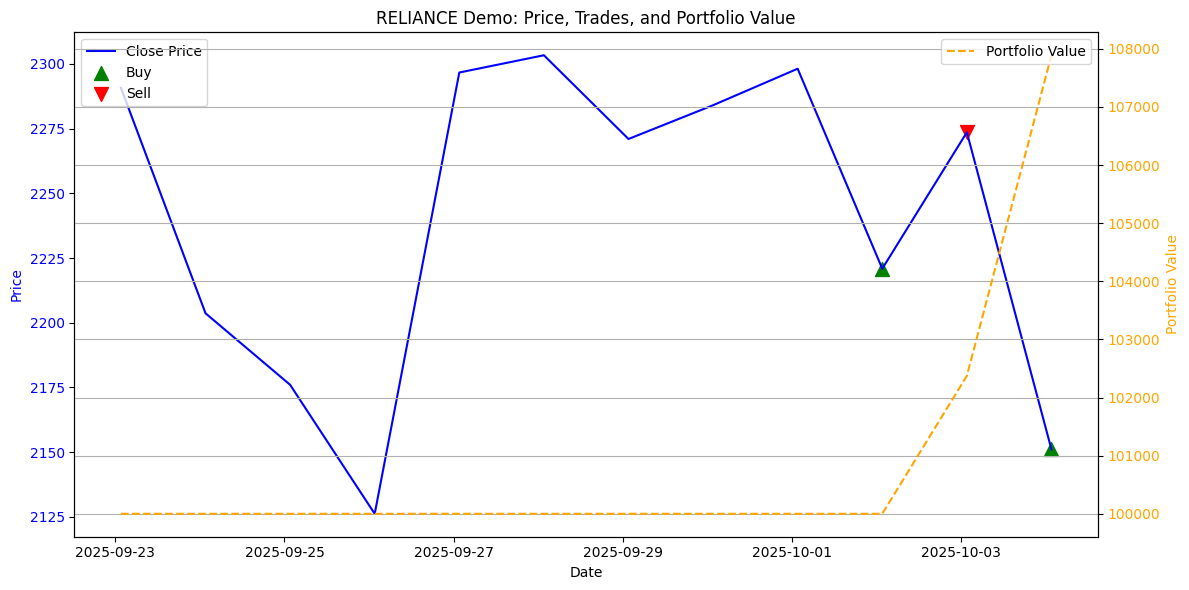

In [43]:
def main():
    symbol = 'RELIANCE'
    days = 12
    capital = 100000

    data_ingestion = DataIngestion([symbol])
    df = data_ingestion.fetch_historical_data(symbol, days)

    df = TechnicalAnalysis.add_indicators(df)
    strategy = TradingStrategy()
    df = strategy.generate_signals(df)

    backtester = Backtester(initial_capital=capital)
    df, trades = backtester.backtest(df)

    ml = MLPredictor()
    accuracy, next_day = ml.train(df)

    print_demo_summary(symbol, df, trades, accuracy, next_day)
    plot_demo(df, trades, symbol)


if __name__ == '__main__':
    main()
